***2.1.*** <br>
I chose to analyse the Bitcoin price in USD because it is one of the most heavily traded financial assets in the world. As a cryptocurrency, Bitcoin operates independently of central banks and traditional financial systems, which makes it a particularly interesting case for time series forecasting. The USD pair was selected over GBP because most global trading is conducted in dollars, and using USD avoids introducing exchange rate noise that could distort the analysis.

Bitcoin’s price is influenced by a range of factors. Macroeconomic variables like inflation, interest rates from the US Federal Reserve, global liquidity and dollar strength play a role in shaping demand. Speculative sentiment, driven by social media activity and search trends, can lead to rapid price movements, especially during bull markets. Regulatory events and institutional activity, such as ETF approvals or adoption by large companies, often trigger significant price shifts. On-chain activity, including transaction volumes, mining performance, halving events and large wallet movements, also contributes to price changes.

Historically, Bitcoin has gone through several boom and bust cycles. Major bull runs occurred in 2017 and again in 2020–2021, often followed by corrections. These cycles tend to align with the halving events, which reduce Bitcoin’s supply growth and can lead to upward pressure on price. Crashes, on the other hand, are often tied to regulatory crackdowns or major exchange failures.

Data for this analysis can be sourced from public APIs, including price history from CryptoCompare, macro data from institutions like the Federal Reserve or IMF, and sentiment data from Google Trends and social media platforms. However, some variables remain difficult to access, such as OTC trading flows, undisclosed whale activity, and the exact timing of regulatory decisions.


***2.2.***

In [18]:
import requests
import pandas as pd
from pandas import json_normalize

api_key = 'f5920c1fc41f69f383d4e0d2a6a4a20e172016b82905ecdb4b9746c4e5b8c4c9'

url = 'https://min-api.cryptocompare.com/data/v2/histoday'
params = {
    'fsym': 'BTC',
    'tsym': 'USD',
    'limit': 500,  # Number of days
    'aggregate': 1
}

headers = {
    'authorization': f'Apikey {api_key}'
}

response = requests.get(url, params=params, headers=headers)
data = response.json()

df = json_normalize(data['Data']['Data'])
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
btc_price = df[['close']].copy()

btc_price.head()

,close
time,
2023-12-09,43723.00
2023-12-10,43791.67
2023-12-11,41235.58
2023-12-12,41472.94
2023-12-13,42887.55


In [19]:
btc_price.to_csv('btc_usd_daily.csv')

***2.3.***

In [3]:
import numpy as np

# Lagged prices
for lag in range(1, 11):
    btc_price[f'lag_{lag}'] = btc_price['close'].shift(lag)

# Rolling statistics (moving averages and volatility)
btc_price['rolling_mean_5'] = btc_price['close'].rolling(window=5).mean()
btc_price['rolling_std_5'] = btc_price['close'].rolling(window=5).std()

# Percentage change
btc_price['pct_change'] = btc_price['close'].pct_change()

# Drop NaN values (due to lags/rolling windows)
btc_price = btc_price.dropna()

btc_price.head()


,close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_5,rolling_std_5,pct_change
time,,,,,,,,,,,,,,
2023-12-19,42268.08,42650.27,41349.42,42243.26,41939.16,43030.60,42887.55,41472.94,41235.58,43791.67,43723.00,42090.038,484.849209,-0.008961
2023-12-20,43669.91,42268.08,42650.27,41349.42,42243.26,41939.16,43030.60,42887.55,41472.94,41235.58,43791.67,42436.188,838.815724,0.033165
2023-12-21,43875.01,43669.91,42268.08,42650.27,41349.42,42243.26,41939.16,43030.60,42887.55,41472.94,41235.58,42762.538,1038.618457,0.004697
2023-12-22,44008.04,43875.01,43669.91,42268.08,42650.27,41349.42,42243.26,41939.16,43030.60,42887.55,41472.94,43294.262,783.523115,0.003032
2023-12-23,43732.75,44008.04,43875.01,43669.91,42268.08,42650.27,41349.42,42243.26,41939.16,43030.60,42887.55,43510.758,706.899449,-0.006255


In [4]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Define features and target
X = btc_price.drop(columns=['close'])
y = btc_price['close']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# ElasticNet with CV (combines L1 and L2 penalties)
model = ElasticNetCV(cv=tscv, l1_ratio=[.1, .5, .7, .9, .95, 1], n_alphas=100, random_state=42)
model.fit(X_scaled, y)

print("Optimal alpha:", model.alpha_)
print("Optimal l1_ratio:", model.l1_ratio_)


Optimal alpha: 17.47448670215071
Optimal l1_ratio: 1.0


In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(btc_price['close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.4082719807431219
p-value: 0.578304064919283


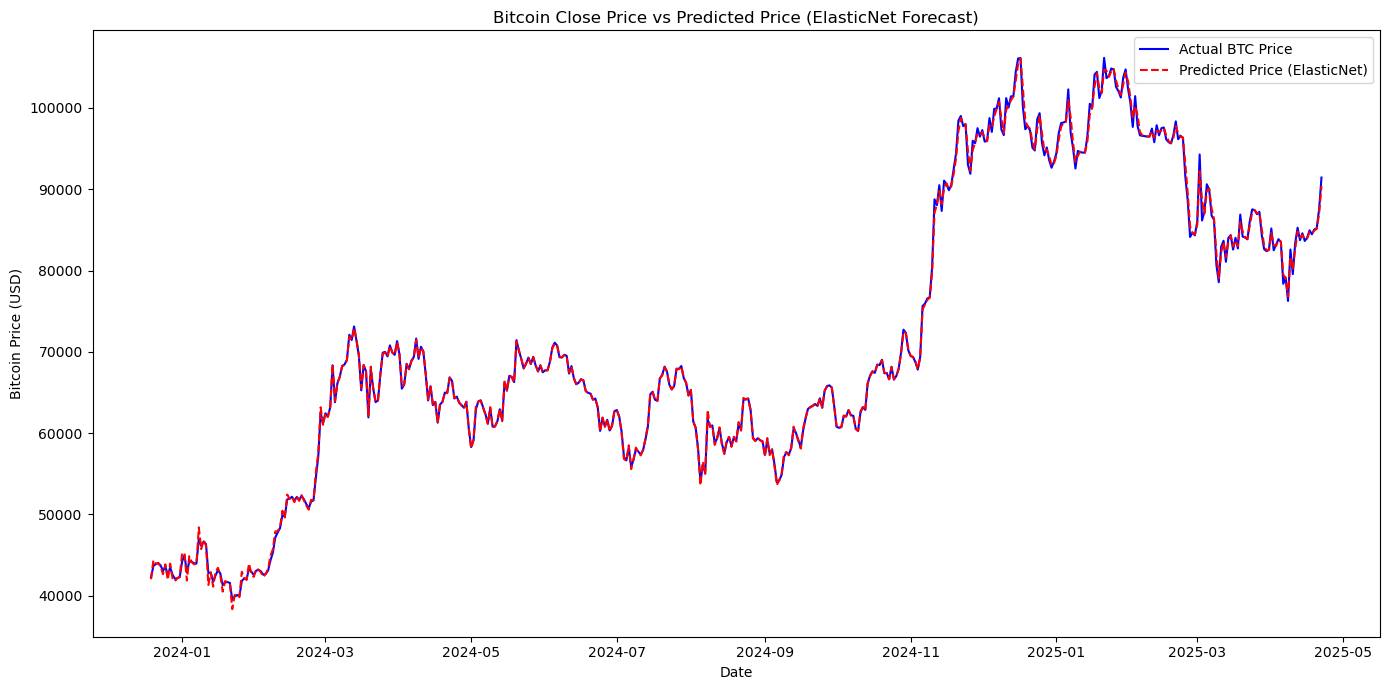

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

# Actual Bitcoin prices (whole dataset)
plt.plot(btc_price.index, y, color='blue', label='Actual BTC Price')

# Predictions from your ElasticNet model
plt.plot(btc_price.index, y_pred, color='red', linestyle='--', label='Predicted Price (ElasticNet)')

# Graph styling
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Close Price vs Predicted Price (ElasticNet Forecast)')
plt.legend()
plt.tight_layout()
plt.show()


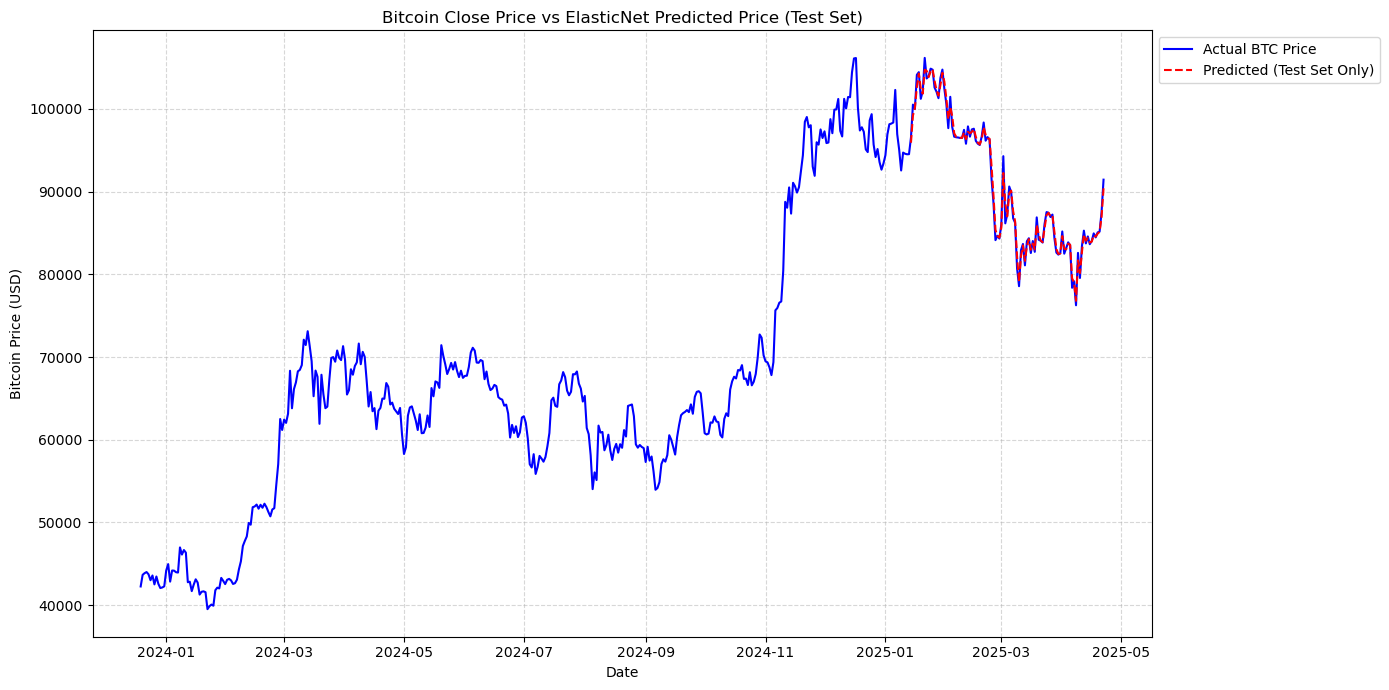

In [15]:
plt.figure(figsize=(14,7))

# Full actual prices
plt.plot(btc_price.index, y, color='blue', label='Actual BTC Price')

# Predicted only on the test section
plt.plot(btc_price.index[train_size:], y_test_pred, color='red', linestyle='--', label='Predicted (Test Set Only)')

plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.title('Bitcoin Close Price vs ElasticNet Predicted Price (Test Set)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
